# Introduction

My name is Christos Galanis, and at the time of writing this notebook, I was a postgraduate student in the Data Science program at the International Hellenic University (IHU) in Greece.

This notebook represents a substantial part of my thesis titled "Dynamic Demand Forecasting and Optimization: Improving the Management of Crisis-Driven Food Supply Chains.". In this notebook the demand forecating phase took place using XGBoost algorithm.

A second notebook focuses on the optimization aspect, employing the Economic Order Quantity (EOQ) model.

A third notebook integrates the concepts of demand forecasting and optimization while demonstrating their application through a web app developed using the Streamlit library.



## **Dataset**

The dataset utilized in this project originates from a Kaggle competition titled ["Food Demand Forecasting"](https://www.kaggle.com/competitions/food-demand-forecasting-iod-week8-ensemblelearning/data).

The company is a meal delivery service operating across multiple cities. To ensure efficient operations, it maintains several fulfillment centers responsible for dispatching meal orders to customers. The company seeks assistance in forecasting future demand to enable these centers to better plan their raw material inventory for the upcoming weeks.

The following files were available through some notebooks except the test file (including weeks 146-155):

*   **train_data** - Includes details about meals in each center for a given week, such as meal ID, base price, checkout price, promotion status (email/homepage), and the number of orders (target variable).
*   **fulfillment_center_data** - Contains center-specific details, including ID, city code, region code, center type, and operation area.
*   **meal_data** - Provides category and cuisine information for each meal.

---

# Import libraries

In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 65.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


In [ ]:
from google.colab import drive
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, LSTM, Dense
from keras.models import Sequential
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, QuantileTransformer
import seaborn as sns
import plotly.express as px
import category_encoders as ce
import math
from matplotlib.offsetbox import AnchoredText
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder


# Load Files

In [ ]:
# Mount the drive
drive.mount('/content/drive')

# Path to the directory
project_dir = '/content/drive/MyDrive/IHU - Data Science/Thesis/Dataset/'

# Change the current working directory to this folder
os.chdir(project_dir)

# Verify the current working directory
print("Current Working Directory:", os.getcwd())


In [ ]:
# Read the files
train_data = pd.read_csv('train.csv')
fulfilment_center_data = pd.read_csv('fulfilment_center_info.csv')
meal_data = pd.read_csv('meal_info.csv')

In [ ]:
train_data.head()

# EDA

Merging the three individual datasets into one can make the analysis process easier

In [ ]:
merged_df = pd.merge(train_data, fulfilment_center_data, on='center_id')
final_merged_df = pd.merge(merged_df, meal_data, on='meal_id')

In [ ]:
# Check the number of rows, columns and on-null values.
# Also, the types of data are taken into account
final_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  int64  
 3   meal_id                456548 non-null  int64  
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   num_orders             456548 non-null  int64  
 9   city_code              456548 non-null  int64  
 10  region_code            456548 non-null  int64  
 11  center_type            456548 non-null  object 
 12  op_area                456548 non-null  float64
 13  category               456548 non-null  object 
 14  cuisine                456548 non-nu

In [ ]:
#The following code prints if there are any null values
print(final_merged_df.isna().sum())

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
city_code                0
region_code              0
center_type              0
op_area                  0
category                 0
cuisine                  0
dtype: int64


Since the dataset includes a variety of meals distributed across different centers over multiple weeks, there is no single time-dependent entity (e.g., one meal in one center over time) to visualize directly. However, by grouping the data based on the "week" attribute, a consistent time series representation can be created, allowing for clearer visualization.

In [ ]:
#See the time series of the meal orders across weeks
df_plot = final_merged_df.groupby(['week'])['num_orders'].sum().reset_index()

# Create the interactive plot
fig = px.line(df_plot,
              x='week',
              y='num_orders',
              markers=True,
              title='Total Weekly Number of Orders',
              labels={'week': 'Week', 'num_orders': 'Number of Orders'})


# Show the interactive plotS
fig.show()


As it can be seen, there is both a simple trend and a seasonality component. There are also some spikes up and down in some cases during the time horizon.

To gain a more detailed view we can jump into a specific meal and center to see the trend and seasonal components of one of the many time series that exist in the dataset.

In [ ]:
#Set variables
center = 55
meal = 1885

df_plot_2 = final_merged_df[(final_merged_df['center_id'] == center) & (final_merged_df['meal_id'] == meal)]
#See the time series of orders of a specific meal of a specific center across weeks

# Create the interactive plot
fig = px.line(df_plot_2,
              x='week',
              y='num_orders',
              markers=True,
              title=f'Weekly Number of Orders for Meal: {meal} and Center: {center}',
              labels={'week': 'Week', 'num_orders': 'Number of Orders'})


# Show the interactive plot
fig.show()


Creation of histogram and boxplot to check the distribution and any outliers of the numerical features of the dataset.

In [ ]:
numerical_features = ['checkout_price', 'base_price', 'num_orders']

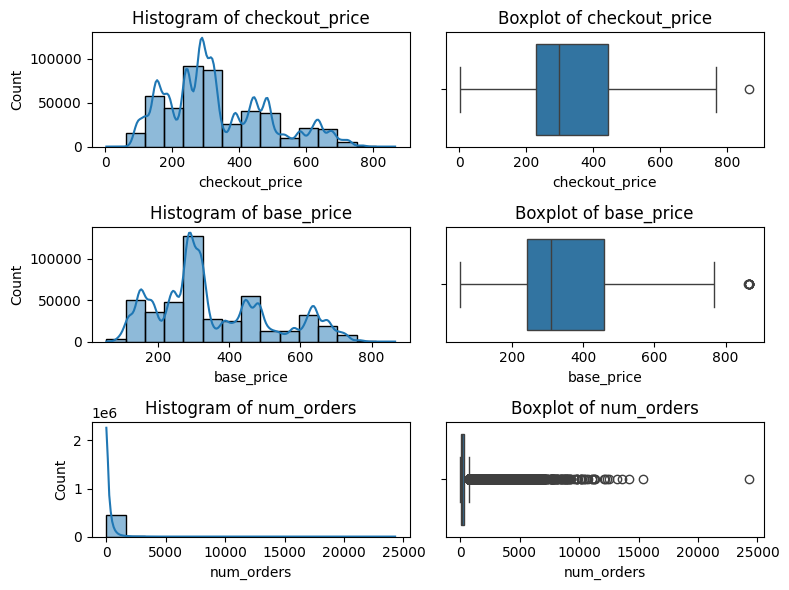

In [ ]:
# Create a 3x3 figure
fig, axes = plt.subplots(3, 2, figsize=(8, 6))

for i, feature in enumerate(numerical_features):
    # Histogram (left column)
    sns.histplot(final_merged_df[feature], bins=15, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f"Histogram of {feature}")

    # Boxplot (right column)
    sns.boxplot(x=final_merged_df[feature], ax=axes[i, 1], orient='h')
    axes[i, 1].set_title(f"Boxplot of {feature}")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

The following two plots demonstrate the correlation between the numerical features of the dataset.

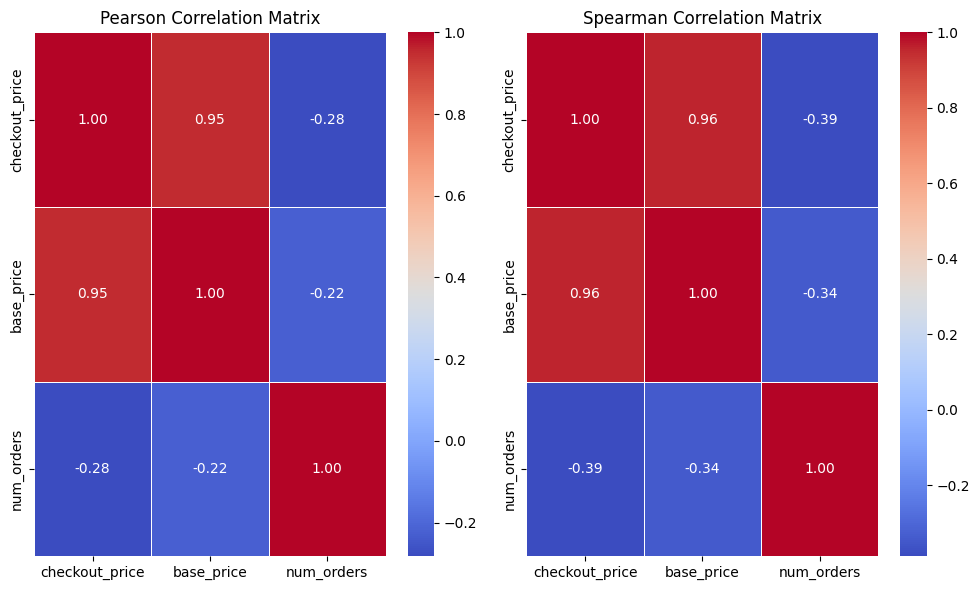

In [ ]:
# Calculate correlation matrices
pearson_corr = final_merged_df[numerical_features].corr(method='pearson')
spearman_corr = final_merged_df[numerical_features].corr(method='spearman')

# Create a 2x2 figure for heatmaps
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Pearson correlation heatmap
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, ax=axes[0])
axes[0].set_title("Pearson Correlation Matrix")

# Spearman correlation heatmap
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, ax=axes[1])
axes[1].set_title("Spearman Correlation Matrix")

# Adjust layout
plt.tight_layout()
plt.show()


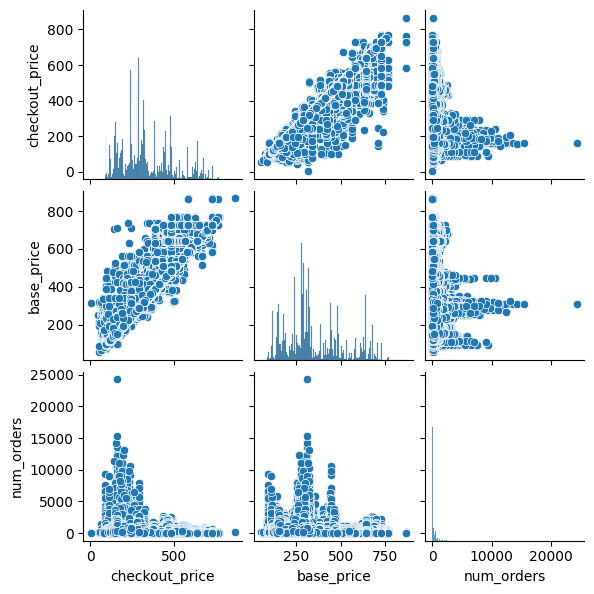

In [ ]:
# Create pairplot
sns.pairplot(final_merged_df[numerical_features], diag_kind='hist', markers="o", height=2.0, aspect=1.0)


From the above two plots it is obvisous that there is high correlation between checkout price and base price.

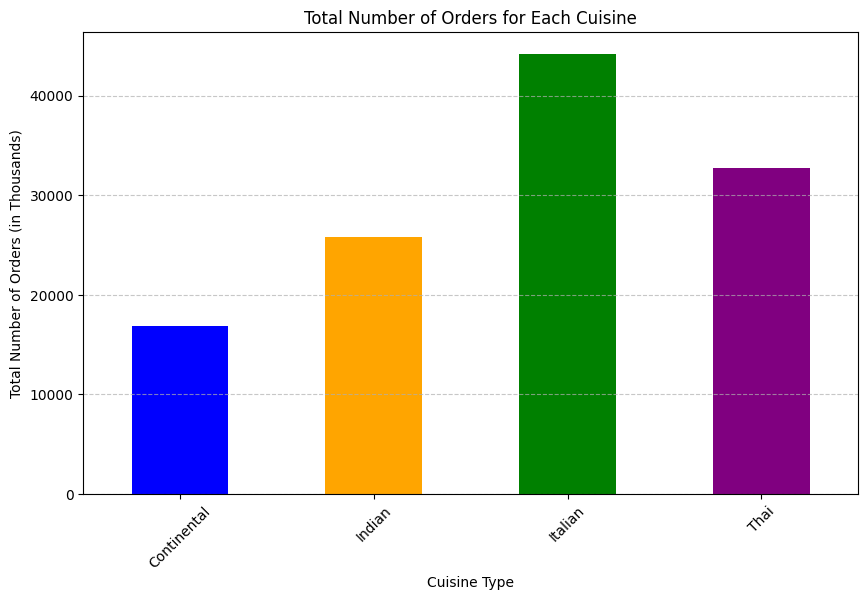

In [ ]:
# Group by 'cuisine' and sum the 'num_orders' feature
cuisine_orders = final_merged_df.groupby('cuisine')['num_orders'].sum()

# Plot using Matplotlib
plt.figure(figsize=(10, 6))
colors = ['blue', 'orange', 'green', 'purple']  # Customize colors
# Divide values by 1,000 to scale to thousands
(cuisine_orders / 1e3).plot(kind='bar', color=colors)

# Add title and labels
plt.title('Total Number of Orders for Each Cuisine')
plt.xlabel('Cuisine Type')
plt.ylabel('Total Number of Orders (in Thousands)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# 1st Attempt with All the data
In this part of the notebook, all the datasets will be merged and given us input to the model

In [ ]:
df_with_all_features = final_merged_df.copy()

In [ ]:
# Slice the data in chronological order to avoid data leakage
training_data = df_with_all_features[df_with_all_features["week"] < 136]
testing_data = df_with_all_features[df_with_all_features["week"] >= 136]


In [ ]:
# Identify categorical features
categorical_features = ['center_id', 'meal_id', 'city_code', 'region_code', 'center_type',
                        'category', 'cuisine', 'op_area']

# Initialize OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # Use sparse_output=False

# Fit the encoder on the categorical features from the training set
one_hot_encoder.fit(training_data[categorical_features])

# Transform the training and test sets
train_encoded = one_hot_encoder.transform(training_data[categorical_features])
test_encoded = one_hot_encoder.transform(testing_data[categorical_features])

# Convert the encoded data to DataFrame, preserving the index
train_encoded_df = pd.DataFrame(train_encoded,
                                columns=one_hot_encoder.get_feature_names_out(categorical_features),
                                index=training_data.index)
test_encoded_df = pd.DataFrame(test_encoded,
                               columns=one_hot_encoder.get_feature_names_out(categorical_features),
                               index=testing_data.index)

# Drop original categorical columns and concatenate the one-hot encoded columns
train_df_encoded = pd.concat([training_data.drop(columns=categorical_features), train_encoded_df], axis=1)
test_df_encoded = pd.concat([testing_data.drop(columns=categorical_features), test_encoded_df], axis=1)

# Check for consistent rows
print("Train shape:", train_df_encoded.shape)
print("Test shape:", test_df_encoded.shape)


Train shape: (423727, 245)
Test shape: (32821, 245)


(None, None)

In [ ]:
# Split the data accordingly into train and test set
X_train, y_train = train_df_encoded.drop(columns=['num_orders']), train_df_encoded['num_orders']
X_test, y_test = test_df_encoded.drop(columns=['num_orders']), test_df_encoded['num_orders']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((423727, 244), (423727,), (32821, 244), (32821,))

In [ ]:
# Define the XGBoost model
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', tree_method = 'hist', device='cuda', random_state=42)

# Define TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)  # Adjust n_splits based on dataset size

# Define the parameter grid
param_grid = {
    'n_estimators': [200, 300, 400, 500, 600],
    'max_depth': [7, 9, 12, 15],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_regressor,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=tscv,                # 3-fold cross-validation
    verbose=2,           # Print progress
    n_jobs=1            # Use all available processors
)

# Fit the grid search to the training data
%time grid_search.fit(X_train, y_train)

# Use the best model to predict on the validation set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Best Parameters: {grid_search.best_params_}")

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5  # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)
mape = (abs((y_test - y_pred) / y_test).mean()) * 100  # Mean Absolute Percentage Error
r2 = r2_score(y_test, y_pred)

# Create a dictionary with the metrics
metrics_data = {
    "Evaluation Metric": [
        "Mean Absolute Error (MAE)",
        "Mean Absolute Percentage Error (MAPE)",
        "Root Mean Squared Error (RMSE)",
        "R² Score"
    ],
    "Value": [
        f"{mae:.2f}",
        f"{mape:.2f}%",
        f"{rmse:.2f}",
        f"{r2:.2f}"
    ]
}

# Convert to a pandas DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Display the table
metrics_df

Fitting 3 folds for each of 60 candidates, totalling 180 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:31:11] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time=   5.6s
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time=   6.7s
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time=  10.3s
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=300; total time=   7.0s
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=300; total time=  10.4s
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=300; total time=  13.4s
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=400; total time=   8.5s
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=400; total time=  13.0s
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=400; total time=  14.7s
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=500; total time=   7.3s
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=500; total time=  10.0s
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=500; total time=  13.5s
[CV] END ..learning_rate=0.0

,Evaluation Metric,Value
0,Mean Absolute Error (MAE),76.99
1,Mean Absolute Percentage Error (MAPE),66.71%
2,Root Mean Squared Error (RMSE),126.29
3,R² Score,0.79


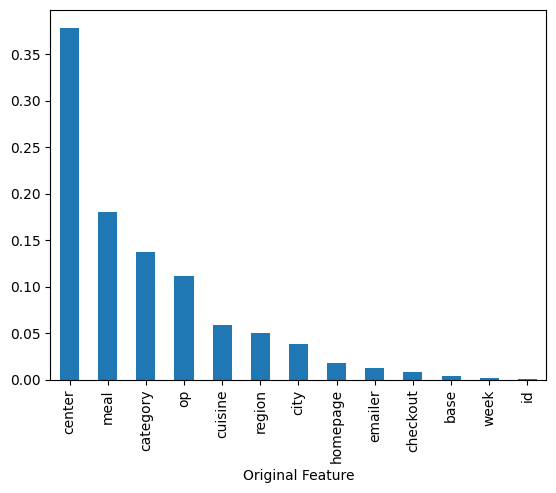

In [ ]:
# Access the booster from the best_model
booster = best_model.get_booster()

# Get feature importance (gain)
importance = booster.get_score(importance_type='gain')

# Create a DataFrame
importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])

# Normalize the Importance
importance_df['Normalized Importance'] = importance_df['Importance'] / importance_df['Importance'].sum()

# Group one-hot encoded features
importance_df['Original Feature'] = importance_df['Feature'].apply(lambda x: x.split('_')[0])

# Aggregate normalized importances
grouped_importance = importance_df.groupby('Original Feature')['Normalized Importance'].sum().reset_index()

# Sort and Plot
grouped_importance = grouped_importance.sort_values(by='Normalized Importance', ascending=False)
grouped_importance.plot(kind='bar', x='Original Feature', y='Normalized Importance', legend=False)
plt.show()


In [ ]:
# Convert the training and test data to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Initialize and train the XGBoost regressor
xgb_params = {
    'objective': 'reg:squarederror',
    'tree_method': 'hist',
    'eval_metric': 'rmse',
    'device': 'cuda',
    'n_estimators': 200,
    'learning_rate': 0.1,
    'max_depth': 7,
    'random_state': 42
}
%time xgb_regressor = xgb.train(xgb_params, dtrain, num_boost_round=200)

# Predict order quantities on the test set
y_pred = xgb_regressor.predict(dtest)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5  # Root Mean Squared Error"
mae = mean_absolute_error(y_test, y_pred)
mape = (abs((y_test - y_pred) / y_test).mean()) * 100  # Mean Absolute Percentage Error
r2 = r2_score(y_test, y_pred)

# Create a dictionary with the metrics
metrics_data = {
    "Metric": [
        "Mean Absolute Error (MAE)",
        "Mean Absolute Percentage Error (MAPE)",
        "Root Mean Squared Error (RMSE)",
        "R² Score"
    ],
    "Value": [
        f"{mae:.2f}",
        f"{mape:.2f}%",
        f"{rmse:.2f}",
        f"{r2:.2f}"
    ]
}

# Convert to a pandas DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Display the table
print(metrics_df)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:30:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


CPU times: user 3.73 s, sys: 69.7 ms, total: 3.8 s
Wall time: 4.3 s
                                  Metric   Value
0              Mean Absolute Error (MAE)   76.70
1  Mean Absolute Percentage Error (MAPE)  67.69%
2         Root Mean Squared Error (RMSE)  126.03
3                               R² Score    0.79


# 2nd attempt - Additional features

In this section, additional features were engineered to assess their impact on the model's performance. The features are:

Dataset-wide features: Simple row-wise features, such as meal profitability or combined categories.


## Dataset-wide features

The features created in the below code cell were introduced in various Kaggle notebooks, including the following examples:

- "R² Score: 80% | 10-Week Food Demand Forecasting" by Ali Almulla
- "END-TO-END Food Demand Forecasting R2 0.90" by Tarık Yılmaz

In [ ]:
df_additional_features = final_merged_df.copy()

In [ ]:
# Discount rate
#df_additional_features['NewDiscountRate'] = (df_additional_features['base_price'] - df_additional_features['checkout_price']) / df_additional_features['base_price']
# Food Profitability
#df_additional_features['NewMealProfitability'] = df_additional_features['base_price'] - df_additional_features['checkout_price']
# Food Category and Center Type Combination
df_additional_features['NewCategoryCenter'] = df_additional_features['category'] + '_' + df_additional_features['center_type'].astype(str)
# Cuisine and Center combination
df_additional_features['NewCuisineCenter'] = df_additional_features['cuisine'] + '_' + df_additional_features['center_type'].astype(str)

In [ ]:
# Slice the data in chronological order to avoid data leakage
train_df = df_additional_features[df_additional_features["week"] < 136]
test_df = df_additional_features[df_additional_features["week"] >= 136]


In [ ]:
train_df = train_df.copy()
test_df = test_df.copy()
train_df.drop(columns=['id'], inplace=True)
test_df.drop(columns=['id'], inplace=True)


In [ ]:
# Identify categorical features
categorical_features = ['center_id', 'meal_id', 'city_code', 'region_code', 'center_type',
                        'category', 'cuisine', 'op_area', 'NewCategoryCenter', 'NewCuisineCenter']

# Initialize OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # Use sparse_output=False

# Fit the encoder on the categorical features from the training set
one_hot_encoder.fit(train_df[categorical_features])

# Transform the training and test sets
train_encoded = one_hot_encoder.transform(train_df[categorical_features])
test_encoded = one_hot_encoder.transform(test_df[categorical_features])

# Convert the encoded data to DataFrame, preserving the index
train_encoded_df = pd.DataFrame(train_encoded,
                                columns=one_hot_encoder.get_feature_names_out(categorical_features),
                                index=train_df.index)
test_encoded_df = pd.DataFrame(test_encoded,
                               columns=one_hot_encoder.get_feature_names_out(categorical_features),
                               index=test_df.index)

# Drop original categorical columns and concatenate the one-hot encoded columns
train_df_encoded = pd.concat([train_df.drop(columns=categorical_features), train_encoded_df], axis=1)
test_df_encoded = pd.concat([test_df.drop(columns=categorical_features), test_encoded_df], axis=1)

# Check for consistent rows
print("Train shape:", train_df_encoded.shape)
print("Test shape:", test_df_encoded.shape)


Train shape: (423727, 298)
Test shape: (32821, 298)


In [ ]:
# Split the data accordingly into train and test set
X_train, y_train = train_df_encoded.drop(columns=['num_orders']), train_df_encoded['num_orders']
X_test, y_test = test_df_encoded.drop(columns=['num_orders']), test_df_encoded['num_orders']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((423727, 297), (423727,), (32821, 297), (32821,))

In [ ]:
# Define the XGBoost model
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', tree_method = 'hist', device='cuda', random_state=42)

# Define TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)  # Adjust n_splits based on dataset size

# Define the parameter grid
param_grid = {
    'n_estimators': [200, 300, 400, 500, 600],
    'max_depth': [7, 9, 12, 15],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_regressor,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=tscv,                # 3-fold cross-validation
    verbose=2,           # Print progress
    n_jobs=1            # Use all available processors
)

# Fit the grid search to the training data
%time grid_search.fit(X_train, y_train)

# Use the best model to predict on the validation set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Best Parameters: {grid_search.best_params_}")

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5  # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)
mape = (abs((y_test - y_pred) / y_test).mean()) * 100  # Mean Absolute Percentage Error
r2 = r2_score(y_test, y_pred)

# Create a dictionary with the metrics
metrics_data = {
    "Evaluation Metric": [
        "Mean Absolute Error (MAE)",
        "Mean Absolute Percentage Error (MAPE)",
        "Root Mean Squared Error (RMSE)",
        "R² Score"
    ],
    "Value": [
        f"{mae:.2f}",
        f"{mape:.2f}%",
        f"{rmse:.2f}",
        f"{r2:.2f}"
    ]
}

# Convert to a pandas DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Display the table
metrics_df

Fitting 3 folds for each of 60 candidates, totalling 180 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:12:13] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time=   3.2s
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time=   5.1s


KeyboardInterrupt: 

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

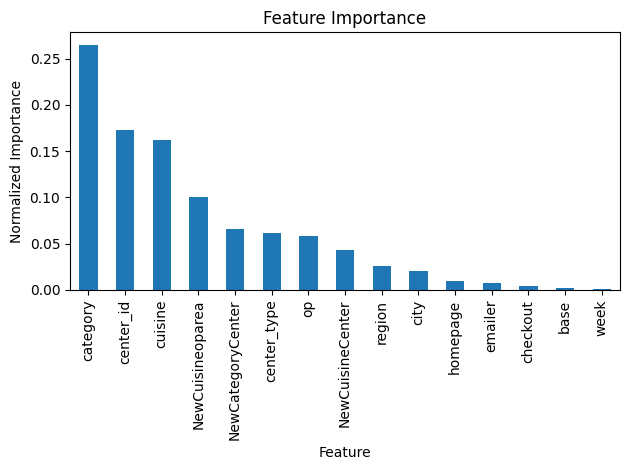

In [ ]:
# Access the booster from the best_model
booster = best_model.get_booster()

# Get feature importance (gain)
#importance = xgb_regressor.get_score(importance_type='gain')

# Get feature importance (gain)
importance = booster.get_score(importance_type='gain')

# Create a DataFrame
importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])

# Normalize the Importance
importance_df['Normalized Importance'] = importance_df['Importance'] / importance_df['Importance'].sum()

# Define grouping logic
def group_feature(feature):
    # Check for one-hot encoded features (assumes these contain '_')
    if feature.startswith('center_id'):
        return 'center_id'  # Group all one-hot encoded center_id features together
    elif feature.startswith('center_type'):
        return 'center_type'  # Group all one-hot encoded center_type features together
    # Check for other one-hot encoded features (assumes these contain '_')
    elif '_' in feature:
        return feature.split('_')[0]  # Group one-hot encoded features by their base name
    else:
        return feature  # Keep other features as-is

# Apply grouping logic
importance_df['Original Feature'] = importance_df['Feature'].apply(group_feature)

# Aggregate normalized importances
# Lag features will not be aggregated since their names are preserved
grouped_importance = (
    importance_df.groupby(['Original Feature'], as_index=False)['Normalized Importance']
    .sum()
)

# Sort the grouped importance
grouped_importance = grouped_importance.sort_values(by='Normalized Importance', ascending=False)

# Plot the feature importance
import matplotlib.pyplot as plt
ax = grouped_importance.plot(kind='bar', x='Original Feature', y='Normalized Importance', legend=False)
ax.set_xlabel("Feature")
ax.set_ylabel("Normalized Importance")
ax.set_title("Feature Importance")
plt.tight_layout()
plt.show()


In [ ]:
# Convert the training and test data to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Initialize and train the XGBoost regressor
xgb_params = {
    'objective': 'reg:squarederror',
    'tree_method': 'hist',
    'eval_metric': 'rmse',
    'device': 'cuda',
    'learning_rate': 0.1,
    'max_depth': 7,
    'random_state': 42
}
%time xgb_regressor = xgb.train(xgb_params, dtrain, num_boost_round=200)

# Predict order quantities on the test set
y_pred = xgb_regressor.predict(dtest)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5  # Root Mean Squared Error"
mae = mean_absolute_error(y_test, y_pred)
mape = (abs((y_test - y_pred) / y_test).mean()) * 100  # Mean Absolute Percentage Error
r2 = r2_score(y_test, y_pred)

# Create a dictionary with the metrics
metrics_data = {
    "Metric": [
        "Mean Absolute Error (MAE)",
        "Mean Absolute Percentage Error (MAPE)",
        "Root Mean Squared Error (RMSE)",
        "R² Score"
    ],
    "Value": [
        f"{mae:.2f}",
        f"{mape:.2f}%",
        f"{rmse:.2f}",
        f"{r2:.2f}"
    ]
}

# Convert to a pandas DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Display the table
print(metrics_df)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:40:06] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:40:06] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


CPU times: user 1min 5s, sys: 270 ms, total: 1min 6s
Wall time: 40 s
                                  Metric   Value
0              Mean Absolute Error (MAE)   76.72
1  Mean Absolute Percentage Error (MAPE)  66.02%
2         Root Mean Squared Error (RMSE)  124.92
3                               R² Score    0.80


# 3rd attempt Lag Features

## Lag Features

Lag Features:
According to [George Kamtziridis](https://medium.com/@geokam/time-series-forecasting-with-xgboost-and-lightgbm-predicting-energy-consumption-with-lag-features-dbf69970a90f) lag features, derived from past target values, play a critical role in time series modeling by capturing serial dependencies. For example, past order quantities can serve as input features to predict current. The number of lags to include depends on the dataset, as each lag provides different levels of information, though excessive lags may lead to redundancy.

Cycles and Lags:
Lag features are particularly useful for capturing non-seasonal cycles (growths and decays) in the data that depend on prior values. Unlike single time series problems where ACF and PACF plots can guide lag selection, the dataset’s structure (multiple meals across various centers) requires creating lag features for each group individually.

Although, calculating lag features is straightforward: the target variable is shifted by the desired lag, in this case the group function was used to separate individual meal-center combinations and prevent data leakage (using future data to predict the past). With the creation of lag features NaN values appear which can be handled efficiently by XGBoost.

Key Structure for Lag Features:
A dictionary was initialized to store lag feature values dynamically. The keys in this dictionary were a combination of center_id, meal_id, and the lag number. This ensured that each lag feature was accurately linked to its specific meal-center combination and iteration step.

Dynamic Calculation of Lag Features in the Prediction Loop:
- Initialization: For the first week of the test set, all lag features were initialized to zero since no prior predictions were available.
- Dynamic Updates: As the model iterated over each row in the test set:
 - For a given test row, the five lag features were dynamically calculated by retrieving the corresponding predictions from the dictionary. For instance, lag1 used the last prediction for the same center_id and meal_id, while lag2 referred to the prediction made two steps earlier, and so on for lag3, lag4, and lag5.
 - If no prior prediction was available for a specific lag, it defaulted to zero for that iteration.

Prediction and Dictionary Update:
- The lag features, dynamically calculated for the current row, were added as input attributes to the model.
- The XGBoost model, trained with optimal hyperparameters from GridSearchCV, made a prediction for the current test row.
- After the prediction, the predicted value was dynamically added to the dictionary under the appropriate key (center_id, meal_id, lag_number). This ensured that future iterations used the most recent predictions for calculating lag features.

Evaluation and Feature Importance:
Once the prediction loop was completed, the model was evaluated against the actual test values using metrics such as MAE, MAPE, RMSE, and R². A feature importance plot was created to assess the contribution of different features, including the lag features. Finally, the model’s performance was tested on a refined dataset with non-significant features removed, using the same optimal hyperparameters from hyperparameter tuning.

This dynamic and iterative handling of lag features ensured accurate predictions while mimicking real-world production scenarios where only past predictions, not actual values, would be available for future forecasting.


In [ ]:
df_with_lags = final_merged_df.copy()

# Food Category and Center Type Combination
df_with_lags['NewCategoryCenter'] = df_with_lags['category'] + '_' + df_with_lags['center_type'].astype(str)
# Cuisine and Center combination
df_with_lags['NewCuisineCenter'] = df_with_lags['cuisine'] + '_' + df_with_lags['center_type'].astype(str)

df_with_lags.drop(columns=['id'], inplace=True)

# Slice the data in chronological order to avoid data leakage
training_data = df_with_lags[df_with_lags["week"] < 136]
testing_data = df_with_lags[df_with_lags["week"] >= 136]

# Add lag features to the training data
for lag in range(1, 6):
    training_data[f'num_orders_lag{lag}'] = training_data.groupby(['center_id', 'meal_id'])['num_orders'].shift(lag)

# Identify categorical features
categorical_features = ['center_id', 'meal_id', 'city_code', 'region_code', 'center_type',
                        'category', 'cuisine', 'op_area', 'NewCategoryCenter', 'NewCuisineCenter']

# Initialize OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit the encoder on the categorical features from the training set
one_hot_encoder.fit(training_data[categorical_features])

# Transform the training and test sets
train_encoded = one_hot_encoder.transform(training_data[categorical_features])
test_encoded = one_hot_encoder.transform(testing_data[categorical_features])

# Convert the encoded data to DataFrame
train_encoded_df = pd.DataFrame(train_encoded,
                                columns=one_hot_encoder.get_feature_names_out(categorical_features),
                                index=training_data.index)
test_encoded_df = pd.DataFrame(test_encoded,
                               columns=one_hot_encoder.get_feature_names_out(categorical_features),
                               index=testing_data.index)

# Drop original categorical columns and concatenate the one-hot encoded columns
train_df_encoded = pd.concat([training_data.drop(columns=categorical_features), train_encoded_df], axis=1)
test_df_encoded = pd.concat([testing_data.drop(columns=categorical_features), test_encoded_df], axis=1)

# Split the data accordingly into train and test set
X_train, y_train = train_df_encoded.drop(columns=['num_orders']), train_df_encoded['num_orders']
X_test, y_test = test_df_encoded.drop(columns=['num_orders']), test_df_encoded['num_orders']

# Define the XGBoost model
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', tree_method = 'hist', device='cuda', random_state=42)

# Define TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)  # Adjust n_splits based on dataset size

# Define the parameter grid
param_grid = {
    'n_estimators': [200, 300, 400, 500, 600],
    'max_depth': [7, 9, 12, 15],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_regressor,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=tscv,                # 3-fold cross-validation
    verbose=2,           # Print progress
    n_jobs=1            # Use all available processors
)

# Fit the grid search to the training data
%time grid_search.fit(X_train, y_train)

# Use the best model to predict on the validation set
best_model = grid_search.best_estimator_

print(f"Best Parameters: {grid_search.best_params_}")

# Sequential Prediction
predictions = []
pred_dict = {}

for i in range(len(X_test)):
    X_test_i = X_test.iloc[i:i+1].copy()

    # Retrieve meal_id and center_id
    original_categories = one_hot_encoder.inverse_transform(
        X_test_i[one_hot_encoder.get_feature_names_out(categorical_features)]
    )
    meal_id, center_id = original_categories[0, 0], original_categories[0, 1]

    # Dynamically update lag features
    for lag in range(1, 6):
        lag_key = (meal_id, center_id, lag)
        if lag_key in pred_dict:
            X_test_i[f"num_orders_lag{lag}"] = pred_dict[lag_key]
        else:
            X_test_i[f"num_orders_lag{lag}"] = 0

    # Reorder columns to match the training set
    X_test_i = X_test_i[expected_feature_names]

    # Predict
    pred = best_model.predict(X_test_i)
    predictions.append(pred[0])

    # Update pred_dict for future lag use
    for lag in range(5, 1, -1):  # Shift lag values
        pred_dict[(meal_id, center_id, lag)] = pred_dict.get((meal_id, center_id, lag - 1), 0)
    pred_dict[(meal_id, center_id, 1)] = pred[0]

# Calculate metrics
mse = mean_squared_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = mse ** 0.5  # Root Mean Squared Error
mae = mean_absolute_error(y_test, predictions)
mape = (abs((y_test - predictions) / y_test).mean()) * 100  # Mean Absolute Percentage Error
r2 = r2_score(y_test, predictions)

# Create a dictionary with the metrics
metrics_data = {
    "Evaluation Metric": [
        "Mean Absolute Error (MAE)",
        "Mean Absolute Percentage Error (MAPE)",
        "Root Mean Squared Error (RMSE)",
        "R² Score"
    ],
    "Value": [
        f"{mae:.2f}",
        f"{mape:.2f}%",
        f"{rmse:.2f}",
        f"{r2:.2f}"
    ]
}

# Convert to a pandas DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Display the table
metrics_df



<ipython-input-7-cee7f38b7440>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data[f'num_orders_lag{lag}'] = training_data.groupby(['center_id', 'meal_id'])['num_orders'].shift(lag)
<ipython-input-7-cee7f38b7440>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data[f'num_orders_lag{lag}'] = training_data.groupby(['center_id', 'meal_id'])['num_orders'].shift(lag)
<ipython-input-7-cee7f38b7440>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Fitting 3 folds for each of 60 candidates, totalling 180 fits


KeyboardInterrupt: 

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [ ]:
df_with_lags = final_merged_df.copy()

# Food Category and Center Type Combination
df_with_lags['NewCategoryCenter'] = df_with_lags['category'] + '_' + df_with_lags['center_type'].astype(str)
# Cuisine and Center combination
df_with_lags['NewCuisineCenter'] = df_with_lags['cuisine'] + '_' + df_with_lags['center_type'].astype(str)

df_with_lags.drop(columns=['id'], inplace=True)

# Slice the data in chronological order to avoid data leakage
training_data = df_with_lags[df_with_lags["week"] < 136]
testing_data = df_with_lags[df_with_lags["week"] >= 136]

# Add lag features to the training data
for lag in range(1, 6):
    training_data[f'num_orders_lag{lag}'] = training_data.groupby(['center_id', 'meal_id'])['num_orders'].shift(lag)

# Identify categorical features
categorical_features = ['meal_id', 'center_id', 'city_code', 'region_code', 'center_type',
                        'category', 'cuisine', 'op_area', 'NewCategoryCenter', 'NewCuisineCenter']

# Initialize OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit the encoder on the categorical features from the training set
one_hot_encoder.fit(training_data[categorical_features])

# Transform the training and test sets
train_encoded = one_hot_encoder.transform(training_data[categorical_features])
test_encoded = one_hot_encoder.transform(testing_data[categorical_features])

# Convert the encoded data to DataFrame
train_encoded_df = pd.DataFrame(train_encoded,
                                columns=one_hot_encoder.get_feature_names_out(categorical_features),
                                index=training_data.index)
test_encoded_df = pd.DataFrame(test_encoded,
                               columns=one_hot_encoder.get_feature_names_out(categorical_features),
                               index=testing_data.index)

# Drop original categorical columns and concatenate the one-hot encoded columns
train_df_encoded = pd.concat([training_data.drop(columns=categorical_features), train_encoded_df], axis=1)
test_df_encoded = pd.concat([testing_data.drop(columns=categorical_features), test_encoded_df], axis=1)

# Split the data accordingly into train and test set
X_train, y_train = train_df_encoded.drop(columns=['num_orders']), train_df_encoded['num_orders']
X_test, y_test = test_df_encoded.drop(columns=['num_orders']), test_df_encoded['num_orders']

# Define the XGBoost model
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', tree_method = 'hist', device='cuda', random_state=42, n_estimators=300, max_depth=7, learning_rate=0.01)

# Fit the grid search to the training data
%time xgb_regressor.fit(X_train, y_train)

# Sequential Prediction
predictions = []
pred_dict = {}

expected_feature_names = X_train.columns.tolist()

for i in range(len(X_test)):
    X_test_i = X_test.iloc[i:i+1].copy()

    # Retrieve meal_id and center_id
    original_categories = one_hot_encoder.inverse_transform(
        X_test_i[one_hot_encoder.get_feature_names_out(categorical_features)]
    )

    meal_id, center_id  = original_categories[0, 0], original_categories[0, 1]

    # Dynamically update lag features
    for lag in range(1, 6):
        lag_key = (meal_id, center_id, lag)
        if lag_key in pred_dict:
            X_test_i[f"num_orders_lag{lag}"] = pred_dict[lag_key]
        else:
            X_test_i[f"num_orders_lag{lag}"] = 0

    # Reorder columns to match the training set
    X_test_i = X_test_i[expected_feature_names]

    # Predict
    pred = xgb_regressor.predict(X_test_i)
    predictions.append(pred[0])

    # Update pred_dict for future lag use
    for lag in range(5, 0, -1):  # Shift lag values
        pred_dict[(meal_id, center_id, lag)] = pred_dict.get((meal_id, center_id, lag - 1), 0)
    pred_dict[(meal_id, center_id, 1)] = pred[0]

# Calculate metrics
mse = mean_squared_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = mse ** 0.5  # Root Mean Squared Error
mae = mean_absolute_error(y_test, predictions)
mape = (abs((y_test - predictions) / y_test).mean()) * 100  # Mean Absolute Percentage Error
r2 = r2_score(y_test, predictions)

# Create a dictionary with the metrics
metrics_data = {
    "Evaluation Metric": [
        "Mean Absolute Error (MAE)",
        "Mean Absolute Percentage Error (MAPE)",
        "Root Mean Squared Error (RMSE)",
        "R² Score"
    ],
    "Value": [
        f"{mae:.2f}",
        f"{mape:.2f}%",
        f"{rmse:.2f}",
        f"{r2:.2f}"
    ]
}

# Convert to a pandas DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Display the table
metrics_df

<ipython-input-7-3e64d6ce4f47>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data[f'num_orders_lag{lag}'] = training_data.groupby(['center_id', 'meal_id'])['num_orders'].shift(lag)
<ipython-input-7-3e64d6ce4f47>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data[f'num_orders_lag{lag}'] = training_data.groupby(['center_id', 'meal_id'])['num_orders'].shift(lag)
<ipython-input-7-3e64d6ce4f47>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

CPU times: user 40.9 s, sys: 630 ms, total: 41.5 s
Wall time: 16.5 s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:47:50] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


,Evaluation Metric,Value
0,Mean Absolute Error (MAE),171.44
1,Mean Absolute Percentage Error (MAPE),74.28%
2,Root Mean Squared Error (RMSE),311.16
3,R² Score,-0.27


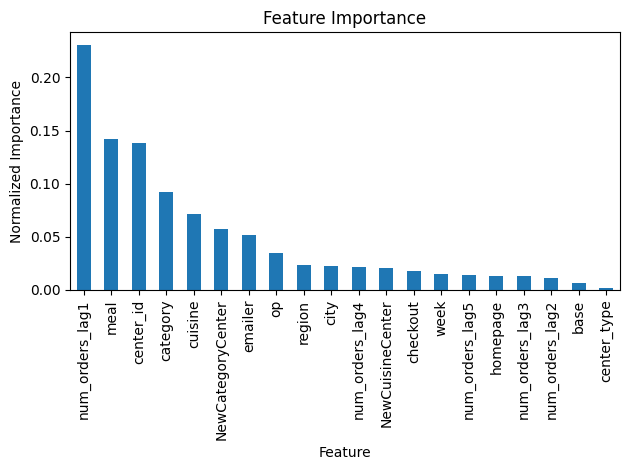

In [ ]:
# Access the booster from the best_model
booster = xgb_regressor.get_booster()

# Get feature importance (gain)
importance = booster.get_score(importance_type='gain')

# Create a DataFrame
importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])

# Normalize the Importance
importance_df['Normalized Importance'] = importance_df['Importance'] / importance_df['Importance'].sum()

# Define grouping logic
def group_feature(feature):
    # Check for one-hot encoded features (assumes these contain '_')
    if feature.startswith('center_id'):
        return 'center_id'  # Group all one-hot encoded center_id features together
    elif feature.startswith('center_type'):
        return 'center_type'  # Group all one-hot encoded center_type features together
    elif feature.startswith('num_orders_lag'):
        return feature  # Group all lag features together
    # Check for other one-hot encoded features (assumes these contain '_')
    elif '_' in feature:
        return feature.split('_')[0]  # Group one-hot encoded features by their base name
    else:
        return feature  # Keep other features as-is

# Apply grouping logic
importance_df['Original Feature'] = importance_df['Feature'].apply(group_feature)

# Aggregate normalized importances
# Lag features will not be aggregated since their names are preserved
grouped_importance = (
    importance_df.groupby(['Original Feature'], as_index=False)['Normalized Importance']
    .sum()
)

# Sort the grouped importance
grouped_importance = grouped_importance.sort_values(by='Normalized Importance', ascending=False)

# Plot the feature importance
import matplotlib.pyplot as plt
ax = grouped_importance.plot(kind='bar', x='Original Feature', y='Normalized Importance', legend=False)
ax.set_xlabel("Feature")
ax.set_ylabel("Normalized Importance")
ax.set_title("Feature Importance")
plt.tight_layout()
plt.show()


In [ ]:
df_with_lags = final_merged_df.copy()

# Food Category and Center Type Combination
df_with_lags['NewCategoryCenter'] = df_with_lags['category'] + '_' + df_with_lags['center_type'].astype(str)
# Cuisine and Center combination
df_with_lags['NewCuisineCenter'] = df_with_lags['cuisine'] + '_' + df_with_lags['center_type'].astype(str)

df_with_lags.drop(columns=['id'], inplace=True)

# Slice the data in chronological order to avoid data leakage
training_data = df_with_lags[df_with_lags["week"] < 136]
testing_data = df_with_lags[df_with_lags["week"] >= 136]

# Add lag features to the training data
for lag in range(1, 2):
    training_data[f'num_orders_lag{lag}'] = training_data.groupby(['center_id', 'meal_id'])['num_orders'].shift(lag)

# Identify categorical features
categorical_features = ['meal_id', 'center_id', 'city_code', 'region_code', 'center_type',
                        'category', 'cuisine', 'op_area', 'NewCategoryCenter', 'NewCuisineCenter']

# Initialize OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit the encoder on the categorical features from the training set
one_hot_encoder.fit(training_data[categorical_features])

# Transform the training and test sets
train_encoded = one_hot_encoder.transform(training_data[categorical_features])
test_encoded = one_hot_encoder.transform(testing_data[categorical_features])

# Convert the encoded data to DataFrame
train_encoded_df = pd.DataFrame(train_encoded,
                                columns=one_hot_encoder.get_feature_names_out(categorical_features),
                                index=training_data.index)
test_encoded_df = pd.DataFrame(test_encoded,
                               columns=one_hot_encoder.get_feature_names_out(categorical_features),
                               index=testing_data.index)

# Drop original categorical columns and concatenate the one-hot encoded columns
train_df_encoded = pd.concat([training_data.drop(columns=categorical_features), train_encoded_df], axis=1)
test_df_encoded = pd.concat([testing_data.drop(columns=categorical_features), test_encoded_df], axis=1)

# Split the data accordingly into train and test set
X_train, y_train = train_df_encoded.drop(columns=['num_orders']), train_df_encoded['num_orders']
X_test, y_test = test_df_encoded.drop(columns=['num_orders']), test_df_encoded['num_orders']

# Define the XGBoost model
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', tree_method = 'hist', device='cuda', random_state=42, n_estimators=300, max_depth=7, learning_rate=0.01)

# Step 5: Fit the grid search to the training data
%time xgb_regressor.fit(X_train, y_train)

# 7. Sequential Prediction
predictions = []
pred_dict = {}

expected_feature_names = X_train.columns.tolist()

for i in range(len(X_test)):
    X_test_i = X_test.iloc[i:i+1].copy()

    # Retrieve meal_id and center_id
    original_categories = one_hot_encoder.inverse_transform(
        X_test_i[one_hot_encoder.get_feature_names_out(categorical_features)]
    )

    meal_id, center_id  = original_categories[0, 0], original_categories[0, 1]

    # Dynamically update lag features
    for lag in range(1, 2):
        lag_key = (meal_id, center_id, lag)
        if lag_key in pred_dict:
            X_test_i[f"num_orders_lag{lag}"] = pred_dict[lag_key]
        else:
            X_test_i[f"num_orders_lag{lag}"] = 0

    # Reorder columns to match the training set
    X_test_i = X_test_i[expected_feature_names]

    # Predict
    pred = xgb_regressor.predict(X_test_i)
    predictions.append(pred[0])

    # Update pred_dict for future lag use
    for lag in range(1, 0, -1):  # Shift lag values
        pred_dict[(meal_id, center_id, lag)] = pred_dict.get((meal_id, center_id, lag - 1), 0)
    pred_dict[(meal_id, center_id, 1)] = pred[0]

# Calculate metrics
mse = mean_squared_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = mse ** 0.5  # Root Mean Squared Error
mae = mean_absolute_error(y_test, predictions)
mape = (abs((y_test - predictions) / y_test).mean()) * 100  # Mean Absolute Percentage Error
r2 = r2_score(y_test, predictions)

# Create a dictionary with the metrics
metrics_data = {
    "Evaluation Metric": [
        "Mean Absolute Error (MAE)",
        "Mean Absolute Percentage Error (MAPE)",
        "Root Mean Squared Error (RMSE)",
        "R² Score"
    ],
    "Value": [
        f"{mae:.2f}",
        f"{mape:.2f}%",
        f"{rmse:.2f}",
        f"{r2:.2f}"
    ]
}

# Convert to a pandas DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Display the table
metrics_df

<ipython-input-7-6e2e7fa29bb2>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data[f'num_orders_lag{lag}'] = training_data.groupby(['center_id', 'meal_id'])['num_orders'].shift(lag)


CPU times: user 38.3 s, sys: 352 ms, total: 38.6 s
Wall time: 15.5 s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:04:51] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


,Evaluation Metric,Value
0,Mean Absolute Error (MAE),132.47
1,Mean Absolute Percentage Error (MAPE),97.44%
2,Root Mean Squared Error (RMSE),245.91
3,R² Score,0.21
